In [8]:
import jax
import jax.numpy as jnp
import xidplus
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
from jax import random
import pylab as plt
%matplotlib inline
import numpy as np

In [103]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers

@jax.partial(jax.jit, static_argnums=(2))
def sp_matmul(A, B, shape):
    """
    http://gcucurull.github.io/deep-learning/2020/06/03/jax-sparse-matrix-multiplication/
    Arguments:
        A: (N, M) sparse matrix represented as a tuple (indexes, values)
        B: (M,K) dense matrix
        shape: value of N
    Returns:
        (N, K) dense matrix
    """
    assert B.ndim == 2
    indexes, values = A
    rows, cols = indexes
    in_ = B.take(cols, axis=0)
    prod = in_*values[:, None]
    res = jax.ops.segment_sum(prod, rows, shape)
    return res

def spire_model(priors,sub=1):

    if len(priors) != 3:
        raise ValueError
    band_plate = numpyro.plate('bands', len(priors),dim=-2)
    src_plate = numpyro.plate('nsrc', priors[0].nsrc,dim=-1)
    psw_plate = numpyro.plate('psw_pixels', priors[0].sim.size, dim=-3, subsample_size=jnp.rint(sub*priors[0].sim.size).astype(int))
    pmw_plate = numpyro.plate('pmw_pixels', priors[1].sim.size, dim=-3, subsample_size=jnp.rint(sub*priors[1].sim.size).astype(int))
    plw_plate = numpyro.plate('plw_pixels', priors[2].sim.size, dim=-3, subsample_size=jnp.rint(sub*priors[2].sim.size).astype(int))
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]

    bkg_prior = jnp.array([p.bkg[0] for p in priors])
    bkg_prior_sig = jnp.array([p.bkg[1] for p in priors])
    nsrc = priors[0].nsrc
    snpix=jnp.asarray([p.snpix for p in priors])
    with band_plate:
        sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1.0,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(-5, 0.5))
    with src_plate:
        src_f_psw = numpyro.sample('src_f_psw',dist.Normal(10,10))
                               #dist.Uniform(priors[0].prior_flux_lower,
                               #             priors[0].prior_flux_upper))
        src_f_pmw = numpyro.sample('src_f_pmw',dist.Normal(10,10))
                               #dist.Uniform(priors[1].prior_flux_lower,
                               #             priors[1].prior_flux_upper))
        src_f_plw = numpyro.sample('src_f_plw',dist.Normal(10,10))
                               #dist.Uniform(priors[2].prior_flux_lower,
                               #             priors[2].prior_flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f_psw[:,None],priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f_pmw[:,None],priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f_plw[:,None],priors[2].snpix).reshape(-1) + bkg[2]
    sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))
    print(db_hat_psw.reshape(-1).shape,sigma_tot_psw.shape,priors[0].sim.shape)
    with psw_plate:# as ind_psw:
        psw_map = numpyro.sample("obs_psw", dist.Normal(db_hat_psw, sigma_tot_psw),
                              obs=priors[0].sim)
    with pmw_plate:# as ind_pmw:
        pmw_map = numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, sigma_tot_pmw),
                              obs=priors[1].sim)
    with plw_plate:# as ind_plw:
        plw_map = numpyro.sample("obs_plw", dist.Normal(db_hat_plw, sigma_tot_plw),
                              obs=priors[2].sim)
    #return 

In [95]:
priors, posterior = xidplus.load('../../../tests/test.pkl')

In [104]:
nuts_kernel = NUTS(spire_model)
mcmc = MCMC(nuts_kernel,num_samples=100,num_warmup=100)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors )
posterior_samples = mcmc.get_samples()

(870,) (870,) (870,)
(870,) (870,) (870,)


  0%|          | 0/200 [00:00<?, ?it/s]

(870,) (870,) (870,)


warmup:   0%|          | 1/200 [00:07<25:07,  7.57s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

(870,) (870,) (870,)


sample: 100%|██████████| 200/200 [01:22<00:00,  2.43it/s, 1023 steps of size 1.18e-38. acc. prob=0.00]


In [106]:
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
       bkg[0,0]      1.30      0.00      1.30      1.30      1.30      0.50      0.99
       bkg[1,0]      0.29      0.00      0.29      0.29      0.29      0.50       nan
       bkg[2,0]      1.90      0.00      1.90      1.90      1.90      0.50      0.99
sigma_conf[0,0]      1.28      0.00      1.28      1.28      1.28      0.50      0.99
sigma_conf[1,0]      6.02      0.00      6.02      6.02      6.02      0.50      0.99
sigma_conf[2,0]      0.28      0.00      0.28      0.28      0.28      0.50      0.99
   src_f_plw[0]      0.54      0.00      0.54      0.54      0.54      0.50      0.99
   src_f_plw[1]      0.06      0.00      0.06      0.06      0.06       nan       nan
   src_f_plw[2]     -1.36      0.00     -1.36     -1.36     -1.36      0.50      0.99
   src_f_plw[3]     -1.50      0.00     -1.50     -1.50     -1.50      0.50      0.99
   src_f_plw[4]      1.62      0.00      1.62      1.

In [107]:
posterior_samples['src_f_psw']

DeviceArray([[-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ],
             [-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ],
             [-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ],
             ...,
             [-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ],
             [-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ],
             [-0.66346645, -1.3929534 , -0.9084854 , ..., -1.9942341 ,
               0.5072365 , -1.3078156 ]], dtype=float32)

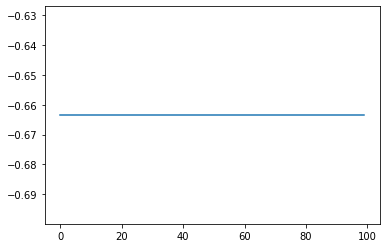

In [110]:
plt.plot(posterior_samples['src_f_psw'][:,0])

In [83]:
posterior_samples['src_f_psw'][:,0]

DeviceArray([13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13.736642, 13.736642,
             13.736642, 13.736642, 13.736642, 13

ValueError: cannot convert float NaN to integer

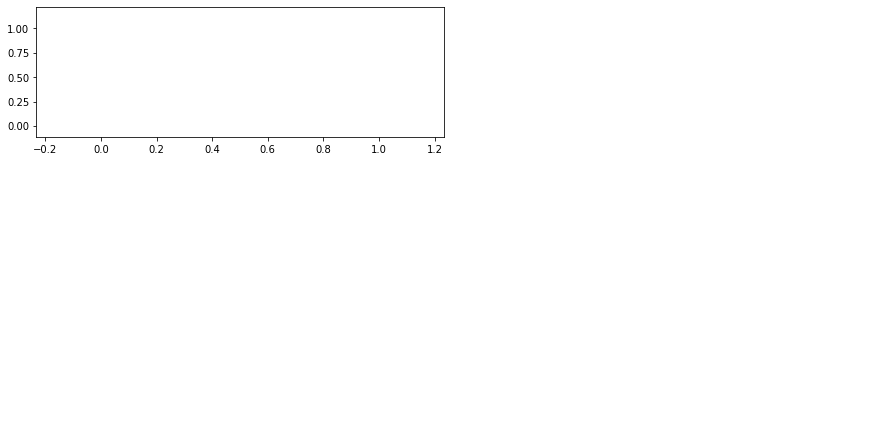

In [157]:
def psw(priors):
    pointing_matrices = [([p.amat_row, p.amat_col], p.amat_data) for p in priors]
    flux_lower=np.asarray([p.prior_flux_lower for p in priors]).T
    flux_upper=np.asarray([p.prior_flux_upper for p in priors]).T
    with numpyro.plate('bands', len(priors)):
        sigma_conf = numpyro.sample('sigma_conf', dist.HalfCauchy(1.0,0.5))
        bkg = numpyro.sample('bkg', dist.Normal(-5, 0.5))
        with numpyro.plate('nsrc', priors[0].nsrc):
            src_f = numpyro.sample('src_f',dist.Uniform(flux_lower,flux_upper))
    db_hat_psw = sp_matmul(pointing_matrices[0], src_f[:,0][:,None],priors[0].snpix).reshape(-1) + bkg[0]
    db_hat_pmw = sp_matmul(pointing_matrices[1], src_f[:,1][:,None],priors[1].snpix).reshape(-1) + bkg[1]
    db_hat_plw = sp_matmul(pointing_matrices[2], src_f[:,2][:,None],priors[2].snpix).reshape(-1) + bkg[2]

    sigma_tot_psw = jnp.sqrt(jnp.power(priors[0].snim, 2) + jnp.power(sigma_conf[0], 2))
    sigma_tot_pmw = jnp.sqrt(jnp.power(priors[1].snim, 2) + jnp.power(sigma_conf[1], 2))
    sigma_tot_plw = jnp.sqrt(jnp.power(priors[2].snim, 2) + jnp.power(sigma_conf[2], 2))
                
    with numpyro.plate('psw_pixels', priors[0].sim.size):# as ind_psw:
        psw_map = numpyro.sample("obs_psw", dist.Normal(db_hat_psw, sigma_tot_psw),
                              obs=priors[0].sim)
    with numpyro.plate('pmw_pixels', priors[1].sim.size):# as ind_pmw:
        pmw_map = numpyro.sample("obs_pmw", dist.Normal(db_hat_pmw, sigma_tot_pmw),
                              obs=priors[1].sim)
    with numpyro.plate('plw_pixels', priors[2].sim.size):# as ind_plw:
        plw_map = numpyro.sample("obs_plw", dist.Normal(db_hat_plw, sigma_tot_plw),
                              obs=priors[2].sim)
    return psw_map

In [175]:
nuts_kernel = NUTS(psw)
mcmc = MCMC(nuts_kernel,num_samples=500,num_warmup=500,num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors)
posterior_samples = mcmc.get_samples()

In [146]:
flux_lower=np.asarray([p.prior_flux_lower for p in priors])

In [150]:
import numpy as np 
np.asarray(flux_lower).shape

(3, 51)

In [162]:
numpyro.util.

AttributeError: module 'numpyro' has no attribute 'ipynb'

In [177]:
mcmc.get_extra_fields()

{'diverging': DeviceArray([False, False, False, ..., False, False, False], dtype=bool)}

In [163]:
import os
cpuCount = os.cpu_count() 


In [164]:
cpuCount

4

In [190]:
from numpyro.diagnostics import print_summary, summary
from numpyro.util import cached_by, fori_collect, identity
from operator import attrgetter

def summary_info(mcmc, prob=0.9, exclude_deterministic=True):
    """
    Print the statistics of posterior samples collected during running this MCMC instance.
    :param float prob: the probability mass of samples within the credible interval.
    :param bool exclude_deterministic: whether or not print out the statistics
        at deterministic sites.
    """
    # Exclude deterministic sites by default
    sites = mcmc._states[mcmc._sample_field]
    if isinstance(sites, dict) and exclude_deterministic:
        state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
        # XXX: there might be the case that state.z is not a dictionary but
        # its postprocessed value `sites` is a dictionary.
        # TODO: in general, when both `sites` and `state.z` are dictionaries,
        # they can have different key names, not necessary due to deterministic
        # behavior. We might revise this logic if needed in the future.
        if isinstance(state_sample_field, dict):
            sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                     if k in state_sample_field}
    
    sum_info=summary(sites, prob=prob)
    extra_fields = mcmc.get_extra_fields()
    
    print("Number of divergences: {}".format(jnp.sum(extra_fields['diverging'])))
        return sum_info,extra_fields['diverging']


In [193]:
test=summary_info(mcmc)

Number of divergences: 0


In [192]:
mcmc.get_extra_fields()

{'diverging': DeviceArray([False, False, False, ..., False, False, False], dtype=bool)}

In [198]:
test[0]['bkg']['r_hat']

array([0.9982147 , 0.99885845, 0.9985092 ], dtype=float32)

In [205]:
posterior_samples['src_f'].shape[1]

51

In [206]:
mcmc._states

{'diverging': DeviceArray([[False, False, False, ..., False, False, False],
              [False, False, False, ..., False, False, False],
              [False, False, False, ..., False, False, False],
              [False, False, False, ..., False, False, False]], dtype=bool),
 'z': {'bkg': DeviceArray([[[-3.109936 , -4.469665 , -5.288051 ],
                [-2.48581  , -4.422443 , -5.561579 ],
                [-3.0357435, -4.4906883, -5.6929107],
                ...,
                [-2.6504626, -4.6225567, -5.216693 ],
                [-2.7703629, -4.4961905, -5.4813104],
                [-2.819275 , -4.6251373, -4.9258156]],
  
               [[-3.2256582, -4.586656 , -5.1443205],
                [-3.0640466, -4.4674706, -5.2415166],
                [-2.5684323, -4.6628094, -5.8423195],
                ...,
                [-2.538409 , -4.606036 , -5.546894 ],
                [-2.8512142, -4.4702506, -5.427948 ],
                [-2.7700255, -4.5644774, -5.779635 ]],
  
           

In [207]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       bkg[0]     -2.78      0.15     -2.78     -3.04     -2.53   3178.37      1.00
       bkg[1]     -4.58      0.21     -4.58     -4.91     -4.24   3411.56      1.00
       bkg[2]     -5.50      0.36     -5.51     -6.10     -4.94   3025.36      1.00
sigma_conf[0]      1.56      0.21      1.57      1.24      1.91   2399.19      1.00
sigma_conf[1]      1.50      0.22      1.51      1.15      1.86   1972.06      1.00
sigma_conf[2]      1.84      0.70      1.94      0.72      3.03    728.98      1.00
   src_f[0,0]      4.40      3.13      3.81      0.00      8.87   2242.84      1.00
   src_f[0,1]      2.53      2.07      2.00      0.00      5.55   2602.46      1.00
   src_f[0,2]      4.62      3.59      3.85      0.00      9.76   3681.46      1.00
   src_f[1,0]      4.92      1.74      4.93      1.73      7.50   1903.58      1.00
   src_f[1,1]      3.85      1.85      3.73      0.96      6.94   1904.32  